In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.15.0


In [3]:
# Create a list with the filepaths for training and testing
train_dir = Path('/Users/dhwanichande/Desktop/IPD/Recognition Dataset/train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [4]:
test_dir = Path('/Users/dhwanichande/Desktop/IPD/Recognition Dataset/test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
val_dir = Path('/Users/dhwanichande/Desktop/IPD/Recognition Dataset/val')
val_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [6]:
def image_processing(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

In [7]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [8]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2780

Number of different labels: 36

Labels: ['capsicum' 'orange' 'lettuce' 'spinach' 'cucumber' 'cauliflower' 'onion'
 'soy beans' 'bell pepper' 'pomegranate' 'kiwi' 'pear' 'sweetcorn' 'apple'
 'garlic' 'lemon' 'mango' 'watermelon' 'grapes' 'cabbage' 'eggplant'
 'beetroot' 'ginger' 'chilli pepper' 'potato' 'tomato' 'peas' 'raddish'
 'turnip' 'paprika' 'banana' 'corn' 'jalepeno' 'carrot' 'pineapple'
 'sweetpotato']


In [9]:
train_df.head(5)

,Filepath,Label
0,/Users/dhwanichande/Desktop/IPD/Recognition Da...,capsicum
1,/Users/dhwanichande/Desktop/IPD/Recognition Da...,orange
2,/Users/dhwanichande/Desktop/IPD/Recognition Da...,lettuce
3,/Users/dhwanichande/Desktop/IPD/Recognition Da...,spinach
4,/Users/dhwanichande/Desktop/IPD/Recognition Da...,cucumber


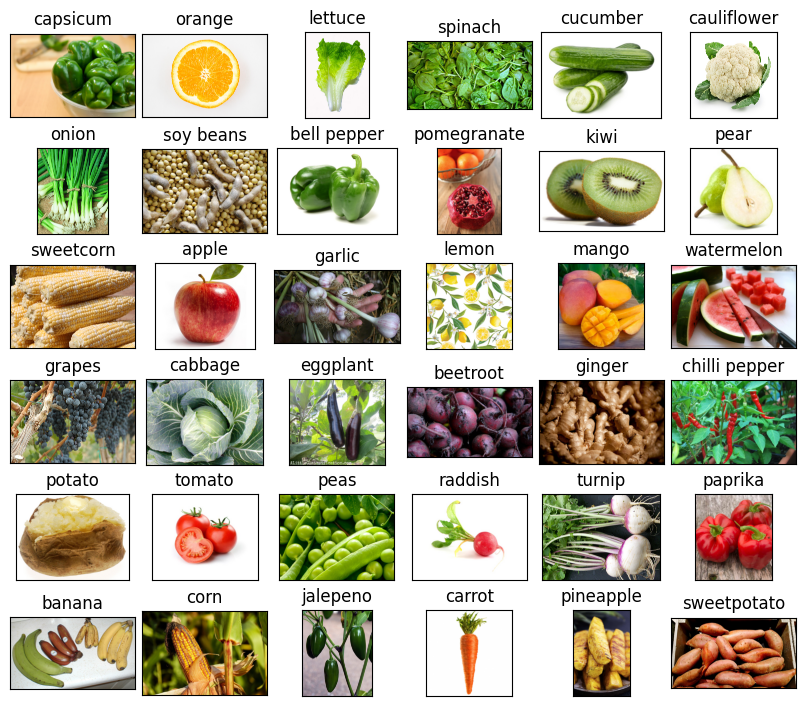

In [10]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [11]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [12]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 2780 validated image filenames belonging to 36 classes.


In [13]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

Found 334 validated image filenames belonging to 36 classes.


In [14]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 334 validated image filenames belonging to 36 classes.


In [15]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [16]:
import scipy
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
87/87 [==============================] - 60s 684ms/step - loss: 1.7957 - accuracy: 0.5345 - val_loss: 0.4430 - val_accuracy: 0.8772
Epoch 2/5
87/87 [==============================] - 57s 657ms/step - loss: 0.5955 - accuracy: 0.8216 - val_loss: 0.3395 - val_accuracy: 0.9102
Epoch 3/5
87/87 [==============================] - 64s 739ms/step - loss: 0.3599 - accuracy: 0.8867 - val_loss: 0.2635 - val_accuracy: 0.9341
Epoch 4/5
87/87 [==============================] - 63s 721ms/step - loss: 0.2265 - accuracy: 0.9320 - val_loss: 0.2348 - val_accuracy: 0.9311
Epoch 5/5
87/87 [==============================] - 60s 688ms/step - loss: 0.1626 - accuracy: 0.9496 - val_loss: 0.1777 - val_accuracy: 0.9641


In [17]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 8s 695ms/step


['pomegranate',
 'sweetpotato',
 'jalepeno',
 'watermelon',
 'jalepeno',
 'turnip',
 'capsicum',
 'lettuce',
 'corn',
 'cauliflower',
 'sweetcorn',
 'pineapple',
 'capsicum',
 'sweetpotato',
 'eggplant',
 'banana',
 'eggplant',
 'paprika',
 'sweetcorn',
 'watermelon',
 'turnip',
 'raddish',
 'apple',
 'pear',
 'orange',
 'mango',
 'watermelon',
 'jalepeno',
 'pineapple',
 'jalepeno',
 'sweetcorn',
 'corn',
 'ginger',
 'lettuce',
 'onion',
 'pomegranate',
 'pineapple',
 'cucumber',
 'grapes',
 'beetroot',
 'mango',
 'banana',
 'paprika',
 'corn',
 'beetroot',
 'potato',
 'peas',
 'capsicum',
 'tomato',
 'turnip',
 'eggplant',
 'corn',
 'eggplant',
 'raddish',
 'apple',
 'soy beans',
 'spinach',
 'cucumber',
 'grapes',
 'capsicum',
 'banana',
 'turnip',
 'chilli pepper',
 'tomato',
 'tomato',
 'carrot',
 'pomegranate',
 'tomato',
 'lemon',
 'soy beans',
 'beetroot',
 'paprika',
 'carrot',
 'corn',
 'pineapple',
 'tomato',
 'orange',
 'paprika',
 'tomato',
 'pear',
 'paprika',
 'eggplant'

In [18]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [19]:
img = output('/Users/dhwanichande/Desktop/IPD/test.jpeg')
img

1/1 [==============================] - 0s 307ms/step


'apple'

In [33]:
model.save('FV.h5')

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Training accuracy: [0.534532368183136, 0.8215827345848083, 0.8866906762123108, 0.9320144057273865, 0.9496402740478516]
Val accuracy: [0.8772454857826233, 0.910179615020752, 0.9341317415237427, 0.93113774061203, 0.9640718698501587]


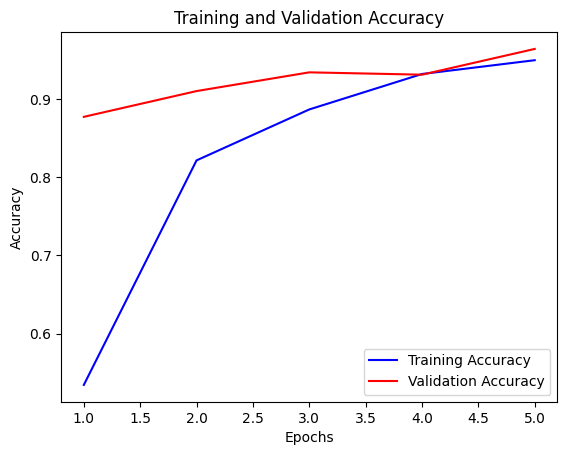

In [22]:
# Access the training and validation accuracy values from the history object
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print('Training accuracy:',training_accuracy)
print('Val accuracy:',validation_accuracy)

# Generate the x-axis values (epochs)
epochs = range(1, len(training_accuracy) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

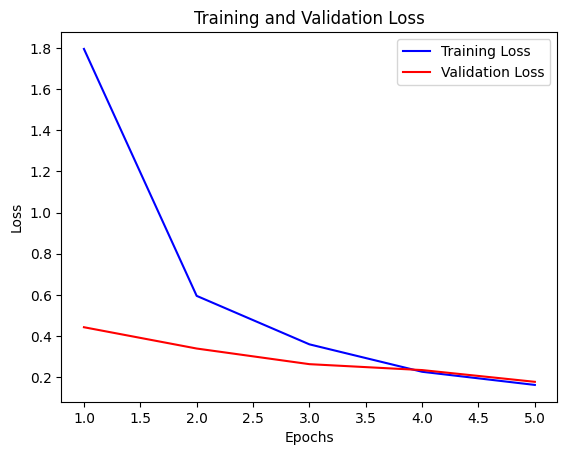

In [23]:
import matplotlib.pyplot as plt

# Access the training and validation loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Generate the x-axis values (epochs)
epochs = range(1, len(training_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [32]:
tloss, taccuracy = model.evaluate(test_images, batch_size=128)

print(f'Test accuracy: {taccuracy}')

11/11 [==============================] - 8s 726ms/step - loss: 0.1777 - accuracy: 0.9641
Test accuracy: 0.9640718698501587
